In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import time as time

In [2]:
# load hairpin data
data_path = '../../../data_toyhairpin/random_sequences_with_custom_hl.hdf5'
with h5py.File(data_path) as dataset:
    X_train_seq = np.expand_dims(np.array(dataset['train_seq']).transpose([0, 2, 1]), axis=2)
    X_train_struct = np.expand_dims(np.array(dataset['train_structures']).transpose([0, 2, 1]), axis=2)
    Y_train = np.expand_dims(np.array(dataset['train_targets']), axis=1)
    X_test_seq = np.expand_dims(np.array(dataset['test_seq']).transpose([0, 2, 1]), axis=2)
    X_test_struct = np.expand_dims(np.array(dataset['test_structures']).transpose([0, 2, 1]), axis=2)
    Y_test = np.expand_dims(np.array(dataset['test_targets']), axis=1)

num_data, seq_length, _, num_alphabet = X_train_seq.shape

# get validation set from training set
valid_frac = 0.2
N = len(X_train_seq)
split_index = int(N*valid_frac)
shuffle = np.random.permutation(N)

# put in a dictionary for deepomics
train = {'inputs': X_train_seq[shuffle[split_index:]], 
         'targets': Y_train[shuffle[split_index:]]}
valid = {'inputs': X_train_seq[shuffle[:split_index]], 
         'targets': Y_train[shuffle[:split_index]]}
test = {'inputs': X_test_seq, 'targets': Y_test}




In [3]:
def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = '../../../results/toyhairpin'
param_path = os.path.join(save_path, 'resbindx')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 41, 1, 4)
layer2: conv1d_0
(?, 30, 1, 96)
layer3: conv1d_0_batch
(?, 30, 1, 96)
layer4: conv1d_0_active
(?, 30, 1, 96)
layer5: conv1d_0_dropout
(?, 30, 1, 96)
layer6: conv1d_residual_0_1resid
(?, 30, 1, 96)
layer7: conv1d_residual_0_1resid_norm
(?, 30, 1, 96)
layer8: conv1d_residual_0_1resid_active
(?, 30, 1, 96)
layer9: conv1d_residual_0_dropout1
(?, 30, 1, 96)
layer10: conv1d_residual_0_2resid
(?, 30, 1, 96)
layer11: conv1d_residual_0_2resid_norm
(?, 30, 1, 96)
layer12: conv1d_residual_0_resid_sum
(?, 30, 1, 96)
layer13: conv1d_residual_0_resid
(?, 30, 1, 96)
layer14: conv1d_residual_0_meanpool
(?, 3, 1, 96)
layer15: conv1d_residual_0_dropout
(?, 3, 1, 96)
layer16: dense_0
(?, 196)
layer17: dense_0_batch
(?, 196)
layer18: dense_0_active
(?, 196)
layer19: dense_0_dropout
(?, 196)
layer20: dens

In [4]:
# initialize session
#sess.close()
sess = utils.initialize_session()

In [ ]:
#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=20, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

In [5]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/toyhairpin/resbindx_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/resbindx_best.ckpt
  test  loss:		0.04233
  test  accuracy:	0.99338+/-0.00000
  test  auc-roc:	0.99974+/-0.00000
  test  auc-pr:		0.99903+/-0.00000


In [6]:
# sort activations
predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
top_outputs = np.argsort(predictionsoutput[:,0])[::-1]

## Progression of layer output for highest predicted sequence


In [9]:
#get sequence
seq=0
X = np.expand_dims(test['inputs'][top_outputs[seq]], axis=0)

INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/resbindx_best.ckpt


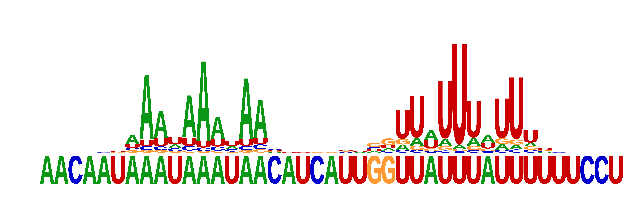

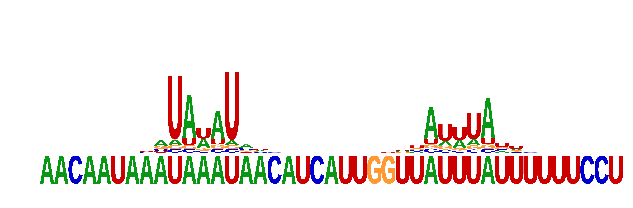

In [35]:
# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

# guided backprop
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=None, params=params)

# plot and save saliency
fig = plt.figure(figsize=(10,3))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                np.squeeze(guided_saliency[0]).T, 
                                alphabet='rna', 
                                nt_width=400)

mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna',
                nntrainer=nntrainer, sess=sess, figsize=(10,3))

In [14]:
guided_saliency.shape

(1, 41, 1, 4)

In [100]:
def backprop(X, layer='output', class_index=None, params=None):
	tf.reset_default_graph()
	if 'use_scope' not in params:
		params['use_scope'] = True

	# build new graph
	model_layers, optimization = params['genome_model'](params['input_shape'], params['output_shape'])
	nnmodel = nn.NeuralNet()
	nnmodel.build_layers(model_layers, optimization, use_scope=params['use_scope'])
	nntrainer = nn.NeuralTrainer(nnmodel, save='best', filepath=params['model_path'])

	# setup session and restore optimal parameters
	sess = utils.initialize_session(nnmodel.placeholders)
	nntrainer.set_best_parameters(sess, params['model_path'], verbose=0)

	# backprop saliency
	if layer == 'output':
		layer = list(nnmodel.network.keys())[-2]
		saliency = nntrainer.get_saliency(sess, X, nnmodel.network[layer], class_index=class_index, batch_size=128)
		saliency = saliency[0]
	else:
		data = {'inputs': X}
		layer_activations = nntrainer.get_activations(sess, data, layer)
		max_activations = np.squeeze(np.max(layer_activations, axis=1))
		active_indices = np.where(max_activations > 0)[0]
		active_indices = active_indices[np.argsort(max_activations[active_indices])[::-1]]

		saliency = []
		for neuron_index in active_indices:
			val = nntrainer.get_saliency(sess, X, nnmodel.network[layer], class_index=None, batch_size=128)
			saliency.append(val)

	sess.close()
	tf.reset_default_graph()
	return saliency

INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/resbindx_best.ckpt


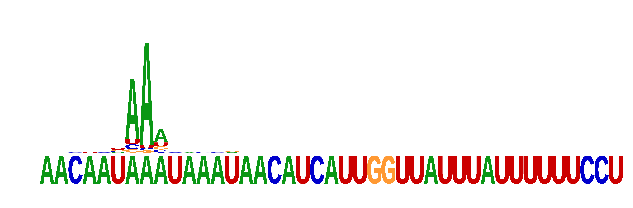

In [101]:
# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

# guided backprop
guided_saliency= backprop(X, layer='conv1d_0_active', class_index=0, params=params)

# plot and save saliency
fig = plt.figure(figsize=(10,3))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                np.squeeze(guided_saliency[0]).T, 
                                alphabet='rna', 
                                nt_width=400)

In [91]:
# saliency parameters  <-- neccessary because we need to rebuild graph using different gradient ops
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

# guided backprop
guided_saliency= saliency.guided_backprop(X, layer='conv1d_0_active', class_index=None, params=params)

# plot and save saliency
fig = plt.figure(figsize=(10,3))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                np.squeeze(guided_saliency[0]).T, 
                                alphabet='rna', 
                                nt_width=400)

INFO:tensorflow:Restoring parameters from ../../../results/toyhairpin/resbindx_best.ckpt


TypeError: 'ActivationLayer' object has no attribute '__getitem__'

In [54]:
data = {'inputs': X}
layer_activations = nntrainer.get_activations(sess, data, 'conv1d_0_active')
layer_activations.shape

(1, 30, 1, 96)

In [56]:
max_activations

array([0.5227205 , 0.8299161 , 0.21115088, 0.49531162, 0.38082317,
       0.3345267 , 0.44474968, 0.39367932, 0.5755929 , 0.02580696,
       0.4600293 , 0.50078326, 0.5737284 , 0.43209857, 0.14235234,
       0.93255395, 0.4588964 , 0.14181662, 0.33831823, 0.42420214,
       0.28827727, 0.        , 0.33894318, 0.264509  , 0.4281989 ,
       0.5253453 , 0.4173791 , 0.3298798 , 0.45918882, 0.2599916 ,
       0.33295798, 0.45035893, 0.6704818 , 0.94423735, 0.36079612,
       0.43329883, 0.8908853 , 0.6040352 , 0.29720533, 0.09825432,
       0.29458702, 0.48733345, 0.5193491 , 0.37987757, 0.1271944 ,
       0.47787905, 0.69847906, 0.4587218 , 0.46278176, 0.38586038,
       0.56389225, 0.        , 0.36873198, 0.05584174, 0.39640093,
       0.5985725 , 0.29816106, 0.0207113 , 0.45534328, 0.49291664,
       0.31995463, 0.50374866, 0.2988782 , 0.3512668 , 0.39078033,
       0.3248546 , 0.23440744, 0.56132454, 0.44022012, 0.01569766,
       0.3776108 , 0.42655936, 0.861426  , 0.5567671 , 0.00873

In [58]:
active_indices1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 93, 94, 95])

In [84]:
nnmodel.network['conv1d_0_active'][0]

TypeError: 'ActivationLayer' object does not support indexing